# 1. Feature evaluation
## Load dependencies and data

Note that tourney_level, player_1 and player_2 should only be used to evaluate specific situations. All other features for a match is the difference in performance/situation for the two players or static features like home_advantage or current surface.

In [44]:
import os
import json
import datetime as dt
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

from IPython.core.display import display
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.feature_selection import RFE
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.svm import SVC
from sklearn.tree import export_graphviz

from definitions import GEN_PATH, ROOT_DIR
from utilities.helper import logger

sns.set_context('notebook')
sns.set_style('white')
sns.set(style="whitegrid")

# Read configuration file
with open(os.path.join(ROOT_DIR, 'config.json')) as f:
    config = json.load(f)

proc_match_filepath = os.path.join(GEN_PATH, config['proc_match_filename'])

# Read data
data = pd.read_hdf(proc_match_filepath, key='matches')

# Notebook wide model parameters
rf_estimators = 100  # future default in sklearn
lr_solver = 'lbfgs'  # Only supports Ridge regularization

## Declare notebook wide functions

In [2]:
@logger
def start_pipe(df):
    return df.copy()

@logger
def one_hot_encode(df):
    df = pd.get_dummies(df, columns=['home_advantage'])

    renames = {
        'home_advantage_-1.0': 'p2_home',
        'home_advantage_0.0': 'none_home',
        'home_advantage_1.0': 'p1_home'
    }

    return df.rename(columns=renames)    

@logger
def extract_main_tourneys(df):
    return df.loc[(df['tourney_level'] == 2) | (df['tourney_level'] == 3)]

@logger
def get_points(df):
    level_map = config['tourney_levels']
    points_map = config['match_points']
    
    def get_match_points(level):
        for key, value in level_map.items():
            if value == level:
                return points_map[key]

    df['match_points'] = df['tourney_level'].apply(get_match_points, convert_dtype=True)
    return df

@logger
def prune_columns(df):
    df.dropna(inplace=True)
    
    # These are only interested for evaluating specific situations
    drop_cols = ['outcome', 'tourney_date', 'tourney_level', 'player_1', 'player_2', 'surface']
    df_y = df['outcome']
    df_x = df.drop(drop_cols, axis=1)
    return df_x, df_y

def plot_rf_feat_imp(importances, columns):
    feat_imp = pd.Series(importances, index=columns)
    feat_imp = feat_imp.sort_values(ascending=False)
    sns.barplot(x=feat_imp.to_list(), y=feat_imp.index, color='b')
    plt.show()

def plot_lr_feat_sign(X, coeffs):
    std_dev = np.std(X, 0)
    influence = std_dev*np.abs(coeffs)
    influence.sort_values(ascending=False, inplace=True)
    sns.barplot(x=influence.to_list(), y=influence.index, color='b')
    plt.show()

def plot_hyperparam(accs, params):
    sns.lineplot(params, accs)
    plt.show()

## Extract training, static validation and test data

For feature selection a static portion of validation data will be used while CV will be used for comparing the different models.

In [3]:
X_data, y_data = (data
    .pipe(one_hot_encode)
    .pipe(prune_columns))

X_train_val, X_test, y_train_val, y_test = train_test_split(X_data, y_data, test_size=0.33, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.33, random_state=42)

display(X_train)

one_hot_encode took=0:00:00.073819 shape=(119314, 20)
prune_columns took=0:00:00.029897 shape=(118414, 14)(118414,)


,rel_total_wins,rel_surface_wins,mutual_wins,mutual_surface_wins,mutual_games,rank_diff,points_grad_diff,rel_climate_wins,rel_recent_wins,rel_tourney_games,age_diff,p2_home,none_home,p1_home
12866,-0.163344,-0.419016,-0.000751,-0.000729,0.000642,0.266091,-0.112679,-0.473597,-0.029251,0.001112,0.282745,0,1,0
4727,0.499204,0.607074,-0.000751,-0.000729,0.000642,-0.215417,0.011909,0.669453,0.711215,0.001112,0.038375,0,0,1
97439,0.112718,0.000748,-0.000751,-0.000729,0.000642,-0.113885,0.433072,-0.235462,-0.635088,2.749733,1.022558,0,1,0
79653,1.327390,0.653715,-0.000751,-0.000729,0.000642,-0.615392,0.075558,0.526571,0.441955,0.393772,1.511728,0,1,0
768,0.333567,-0.045892,-0.000751,-0.000729,0.000642,0.064565,-0.023300,0.621826,-1.678472,0.001112,-0.773217,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
22710,-1.709291,-1.724949,-2.882577,-2.818802,-1.677547,1.435250,-0.424150,-1.664274,-0.500457,0.001112,-0.032973,0,0,1
12718,-0.218557,-2.611118,-0.000751,-0.000729,0.000642,-0.264645,0.181187,-0.044953,-0.433142,0.001112,0.031241,1,0,0
29932,-1.764503,-1.491747,-0.000751,-0.000729,0.000642,2.089055,-0.023300,-1.807155,-1.577499,0.001112,0.159668,0,1,0
14603,1.658665,0.793636,-0.000751,-0.000729,0.000642,-0.744615,0.070141,1.479113,0.946818,0.001112,-0.038325,0,0,1


## Correlation heatmap of all features

This shows a high correlation between some of the features (which is naturual). Find out which to remove by checking the feature importance in the next steps.

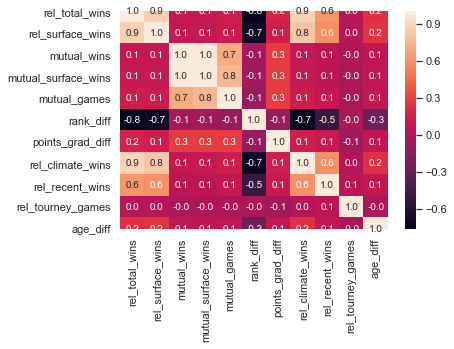

In [4]:
X_train_heat = X_train.drop(['p2_home', 'none_home', 'p1_home'], axis=1)
sns.heatmap(X_train_heat.corr(), annot=True, fmt='.1f')
plt.show()

## Feature importance by RandomForest
Which features help split our tree in the best way possible, i.e. how does each feature affect the accuracy of our model?

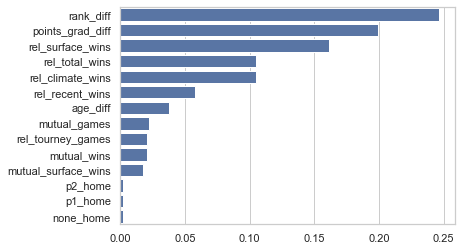

In [5]:
rf_max_depth = 10  # arbitrary number used only for feature evaluation
rf_model = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_estimators)
rf_model.fit(X_train, y_train)
plot_rf_feat_imp(rf_model.feature_importances_, X_train.columns)

## Recursive feature elimination by RandomForest
Prunes the results from previous sections by selecting the 4 most important features. A ranking of 1 means the algorithm suggests the feature. Since the 4th suggestion is a highly correlated one, for linear models only 3 features will be used.

In [80]:
rfe_model = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_estimators)
rfe_model = RFE(rfe_model, n_features_to_select=3)  # selects 3 of the features
rfe_model.fit(X_train, y_train)

rankings = rfe_model.ranking_
idx = np.argsort(rankings)
rankings = rankings[idx]
columns = X_train.columns[idx]

rfe_results = pd.DataFrame(rankings, index=columns, columns=['Ranking'])
rfe_results.index.name = 'Feature'
display(rfe_results)

print(f"Number of features selected: {rfe_model.n_features_}")

,Ranking
Feature,
rel_surface_wins,1
rank_diff,1
points_grad_diff,1
rel_total_wins,2
rel_climate_wins,3
rel_recent_wins,4
age_diff,5
mutual_games,6
rel_tourney_games,7


Number of features selected: 3


## Feature importance by logistic regression

Below mostly confirms 3 most important features from RF model.

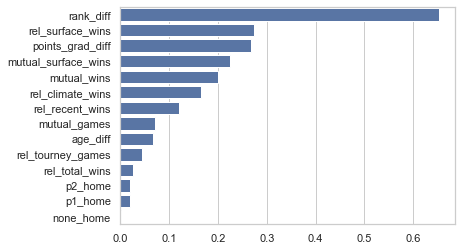

In [7]:
lr_model = LogisticRegression(solver=lr_solver)
lr_model.fit(X_train, y_train)    
plot_lr_feat_sign(X_train, lr_model.coef_[0])

## Prune correlated and poorly significant features for both models

Keep the most significant features but remove any the highly correlated features that are less significant, resulting the below 3 suggestions.

Correlation plot for reduced RandomForest model


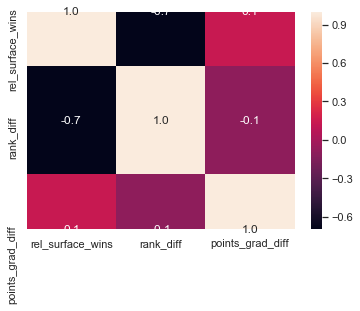

Feature importance for reduced RandomForest model


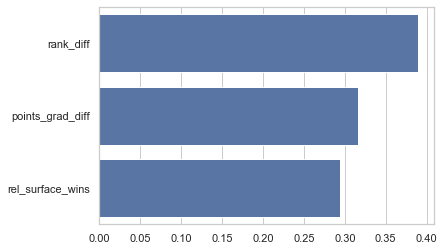

Feature importance for reduced LogReg model


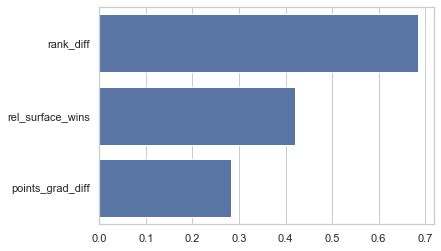

In [82]:
rf_cols = ['rel_surface_wins', 'rank_diff', 'points_grad_diff']

X_train_rf = X_train.filter(rf_cols)

print('Correlation plot for reduced RandomForest model')
sns.heatmap(X_train_rf.corr(), annot=True, fmt='.1f')
plt.show()

rf_model_red = RandomForestClassifier(max_depth=rf_max_depth, n_estimators=rf_estimators)
rf_model_red.fit(X_train_rf, y_train)

lr_model_red = LogisticRegression(solver=lr_solver)
lr_model_red.fit(X_train_rf, y_train)

# Check new feature importances and significance
print('Feature importance for reduced RandomForest model')
plot_rf_feat_imp(rf_model_red.feature_importances_, X_train_rf.columns)

print('Feature importance for reduced LogReg model')
plot_lr_feat_sign(X_train_rf, lr_model_red.coef_[0])

## Check accuracies full and reduced models

Note that there is no need for classification reports since the set is completely balanced. Minor performance decrease for the reduced linear models.

In [85]:
X_val_rf = X_val.filter(rf_cols)

print("Full RandomForest accuracy: %0.3f" % accuracy_score(y_val, rf_model.predict(X_val)))
print("Reduced RandomForest accuracy: %0.3f" % accuracy_score(y_val, rf_model_red.predict(X_val_rf)))
print("Full LogReg accuracy: %0.3f" % accuracy_score(y_val, lr_model.predict(X_val)))
print("Reduced LogReg accuracy: %0.3f" % accuracy_score(y_val, lr_model_red.predict(X_val_rf)))

Full RandomForest accuracy: 0.681
Reduced RandomForest accuracy: 0.677
Full LogReg accuracy: 0.682
Reduced LogReg accuracy: 0.679


# 2. Model Selection

This part is dedicated to hyper parameter tuning and model selection. Cross validation will be used to compare the models but not to tune the hyperparameters.

Also, all linear models will be evaluated using the four final features identified above. However, for the SVM and Neural Network, all features will be considered.

In [25]:
no_folds = 10  # number of folds

## Logistic Regression

### Calibration
Calibration of hyperparameter C which is the inverse of regularization strength.

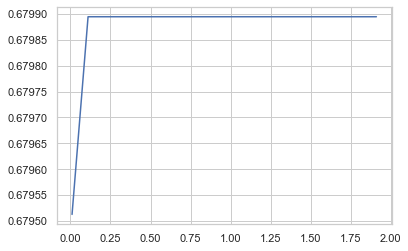

Best C: 0.11 with accuracy: 0.6798945840653884


In [86]:
accuracies = []
c_vals = list(np.arange(0.01, 2, 0.1))
best_acc = 0
best_c = 0

for c in c_vals:
    lr_model_cal = LogisticRegression(solver=lr_solver, C=c)
    lr_model_cal.fit(X_train_lr, y_train)
    predictions = lr_model_cal.predict(X_val_lr)
    acc = accuracy_score(y_val, predictions)
    
    if acc > best_acc:
        best_acc = acc
        best_c = c
    
    accuracies.append(acc)

plot_hyperparam(accuracies, c_vals)

print(f"Best C: {best_c} with accuracy: {best_acc}")

### Cross validation score

In [87]:
X_train_val_lr = X_train_val.filter(lr_cols)
optimal_c = 1  # does not affect as long as reasonable high
lr_model_final = LogisticRegression(solver=lr_solver, C=optimal_c)
lr_scores = cross_val_score(lr_model_final, X_train_val_lr, y_train_val, cv=no_folds)
print("Logistic Regression accuracy: %0.3f (+/- %0.3f)" % (lr_scores.mean(), lr_scores.std() * 2))

Logistic Regression accuracy: 0.678 (+/- 0.013)


## Random Forest

### Calibration

Calibration of max tree depth

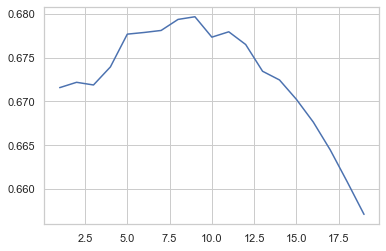

Best max_depth: 9 with accuracy: 0.6796654189901459


In [36]:
accuracies = []
depths = list(np.arange(1, 20, 1))
best_acc = 0
best_depth = 0

for max_depth in depths:
    rf_model_cal = RandomForestClassifier(max_depth=max_depth, n_estimators=rf_estimators)
    rf_model_cal.fit(X_train_rf, y_train)
    predictions = rf_model_cal.predict(X_val_rf)
    acc = accuracy_score(y_val, predictions)
    
    if acc > best_acc:
        best_acc = acc
        best_depth = max_depth
    
    accuracies.append(acc)

plot_hyperparam(accuracies, depths)

print(f"Best max_depth: {best_depth} with accuracy: {best_acc}")

### Cross validation score

In [38]:
X_train_val_rf = X_train_val.filter(rf_cols)
optimal_max_depth = 9
rf_model_final = RandomForestClassifier(max_depth=optimal_max_depth, n_estimators=rf_estimators)
rf_scores = cross_val_score(rf_model_final, X_train_val_rf, y_train_val, cv=no_folds)
print("Random Forest accuracy: %0.3f (+/- %0.3f)" % (rf_scores.mean(), rf_scores.std() * 2))

Random Forest accuracy: 0.678 (+/- 0.010)


## k-Neighbours

### Calibration of number of neighbors with uniform weighting

Testing with both features for RF and LR.

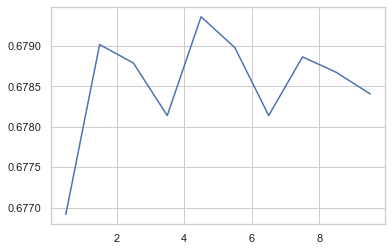

Best factor uniform: 4.5 (base k: 230.5536813846181) with accuracy: 0.6793598655564892


In [41]:
def calibrate_neighbors(base_k, weights):
    accuracies = []
    k_factors = list(np.arange(0.5, 10, 1))
    best_acc = 0
    best_factor = 0

    for factor in k_factors:
        k = int(round(base_k * factor))
        knn_model = KNeighborsClassifier(n_neighbors=k, weights=weights)
        knn_model.fit(X_train_rf, y_train)
        predictions = knn_model.predict(X_val_rf)
        acc = accuracy_score(y_val, predictions)

        if acc > best_acc:
            best_acc = acc
            best_factor = factor

        accuracies.append(acc)
        
    return accuracies, k_factors, best_factor, best_acc

base_k = len(X_train_final) ** 0.5
accuracies, k_factors, best_factor, best_acc = calibrate_neighbors(base_k, 'uniform')
plot_hyperparam(accuracies, k_factors)

print(f"Best factor uniform: {best_factor} (base k: {base_k}) with accuracy: {best_acc}")

### Calibration of number of neighbors with distance weighting

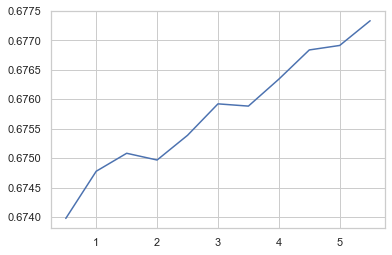

Best factor distance: 5.5 (base k: 230.5536813846181) with accuracy: 0.6773355740585135


In [40]:
base_k = len(X_train_final) ** 0.5
accuracies, k_factors, best_factor, best_acc = calibrate_neighbors(base_k, 'distance')
plot_hyperparam(accuracies, k_factors)

print(f"Best factor distance: {best_factor} (base k: {base_k}) with accuracy: {best_acc}")

### Cross validation score

In [54]:
optimal_factor = 5
optimal_k = int(round(len(X_train_final) ** 0.5 * optimal_factor))
optimal_weight_func = 'uniform'

knn_model_final = KNeighborsClassifier(n_neighbors=optimal_k, weights=optimal_weight_func)
knn_scores = cross_val_score(knn_model_final, X_train_final_full, y_train_full, cv=no_folds)
print("kNN accuracy: %0.3f (+/- %0.3f)" % (knn_scores.mean(), knn_scores.std() * 2))

kNN accuracy: 0.684 (+/- 0.025)


### Experiment: Testing AdaBoost model

Full AdaBoost accuracy: 0.681


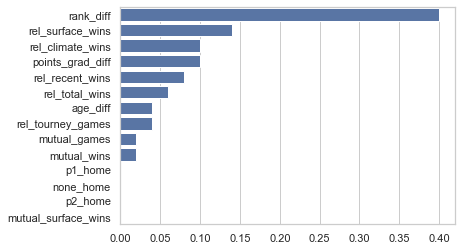

Reduced AdaBoost accuracy: 0.679


In [53]:
# On full
ada_model = AdaBoostClassifier()
ada_model.fit(X_train, y_train)
predictions = ada_model.predict(X_val)

print('Full AdaBoost accuracy: %.3f' % accuracy_score(y_val, predictions))
plot_rf_feat_imp(ada_model.feature_importances_, X_train.columns)

# On reduced
ada_model_red = AdaBoostClassifier()
ada_model_red.fit(X_train_rf, y_train)
predictions = ada_model_red.predict(X_val_rf)

print('Reduced AdaBoost accuracy: %.3f' % accuracy_score(y_val, predictions))

## SVM

Using a sub sample to evaluate the SVM beause it scales super badly. Also, assuming parameters can be calibrated seperately, even if this is probably not the case all the time.

### Calibration of kernel

Length of train data: 53155, val data: 26182
Sample size train data: 20000, val data: 2000


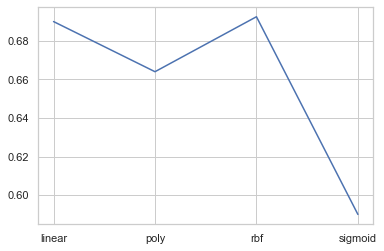

Best kernel: rbf with accuracy: 0.6925


In [55]:
kernels = ['linear', 'poly', 'rbf', 'sigmoid']
accuracies = []
best_acc = 0
best_kernel = ''

sample_size_train = 20000
sample_size_val = 2000

print(f"Length of train data: {len(X_train_rf)}, val data: {len(X_val_rf)}")
print(f"Sample size train data: {sample_size_train}, val data: {sample_size_val}")

X_train_red_svm = X_train_rf.sample(sample_size_train, random_state=42)
X_val_red_svm = X_val_rf.sample(sample_size_val, random_state=42)
y_train_red_svm = y_train[X_train_red_svm.index]
y_val_red_svm = y_val[X_val_red_svm.index]

for kernel in kernels:
    svm_model_cal = SVC(C=1, kernel=kernel, gamma='scale')
    svm_model_cal.fit(X_train_red_svm, y_train_red_svm)
    predictions = svm_model_cal.predict(X_val_red_svm)
    acc = accuracy_score(y_val_red_svm, predictions)

    if acc > best_acc:
        best_acc = acc
        best_kernel = kernel

    accuracies.append(acc)

plot_hyperparam(accuracies, kernels)
print(f"Best kernel: {best_kernel} with accuracy: {best_acc}")

### Calibration of gamma

Using kernel (rbf) best kernel from above experiment

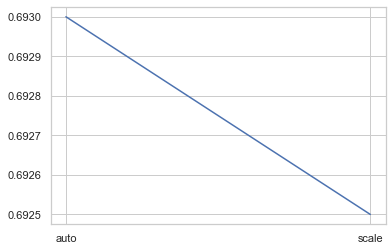

Best gamma: auto with accuracy: 0.693


In [60]:
optimal_kernel = 'rbf'
gammas = ['scale', 'auto']
accuracies = []
best_acc = 0
best_gamma = ''

for gamma in gammas:
    svm_model_cal = SVC(C=1, kernel=optimal_kernel, gamma=gamma)
    svm_model_cal.fit(X_train_red_svm, y_train_red_svm)
    predictions = svm_model_cal.predict(X_val_red_svm)
    acc = accuracy_score(y_val_red_svm, predictions)

    if acc > best_acc:
        best_acc = acc
        best_gamma = gamma

    accuracies.append(acc)

plot_hyperparam(accuracies, gammas)
print(f"Best gamma: {best_gamma} with accuracy: {best_acc}")

### Calibration of regularization parameter C

This takes a couple of minutes.

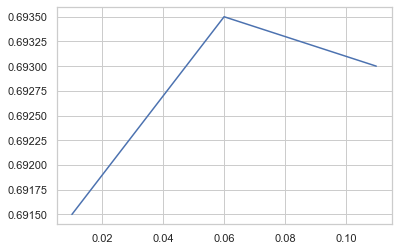

Best C: 0.060000000000000005 with accuracy: 0.6935


In [64]:
optimal_kernel = 'rbf'
optimal_gamma = 'auto'
accuracies = []
c_vals = list(np.arange(0.01, 0.12, 0.05))
best_acc = 0
best_c = 0

for c in c_vals:
    svm_model_cal = SVC(C=c, kernel=optimal_kernel, gamma=optimal_gamma)
    svm_model_cal.fit(X_train_red_svm, y_train_red_svm)
    predictions = svm_model_cal.predict(X_val_red_svm)
    acc = accuracy_score(y_val_red_svm, predictions)
    
    if acc > best_acc:
        best_acc = acc
        best_c = c
    
    accuracies.append(acc)

plot_hyperparam(accuracies, c_vals)

print(f"Best C: {best_c} with accuracy: {best_acc}")

### Cross validation score on SVM model

Since SVM scales very badly, cross validation will only performed once for the full model. This takes about an hour...

In [81]:
optimal_kernel = 'rbf'
optimal_gamma = 'auto'
optimal_c = 0.06

svm_model_final = SVC(C=optimal_c, kernel=optimal_kernel, gamma=optimal_gamma)
svm_scores = cross_val_score(svm_model_final, X_train_val_rf, y_train_val, cv=no_folds)
print("SVM accuracy: %0.3f (+/- %0.3f)" % (svm_scores.mean(), svm_scores.std() * 2))

SVM accuracy: 0.678 (+/- 0.006)


### Experiment: Using SVM on all features

Using the determined gamma type and kernel above and playing around with C to reach a good value. Playing around with all the different features yielded a best result below. Does not seem to be able to extract any significance from more features, rather the opposite.

In [67]:
optimal_kernel = 'rbf'
optimal_gamma = 'auto'
optimal_c = 1

sample_size_train = 20000
sample_size_val = 2000
X_train_svm = X_train.sample(sample_size_train, random_state=42)
X_val_svm = X_val.sample(sample_size_val, random_state=42)
y_train_svm = y_train[X_train_svm.index]
y_val_svm = y_val[X_val_svm.index]

svm_model_full = SVC(C=optimal_c, kernel=optimal_kernel, gamma=optimal_gamma)
svm_model_full.fit(X_train_svm, y_train_svm)
predictions = svm_model_full.predict(X_val_svm)
acc = accuracy_score(y_val_svm, predictions)
    
print(f"Full SVM model accuracy: {acc}")

Full SVM model accuracy: 0.6855


## Neural Network

A maximum of 2 hidden layers with a different amount of nodes will be evaluated given (more than 2 seems unnecessary given the complexity of the problem). Also, assuming activation function, alpha and number of layers/nodes can be calibrated seperately. A Neural Network trained on all featres will be tested in the end.

### Calibration of activation function

Using 1 hidden layer and rule of thumb nodes = 2/3 \* input size + output size

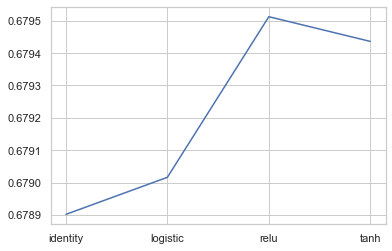

Best activation: relu with accuracy: 0.6795126422733175


In [68]:
no_nodes = int(round(len(X_train_rf.columns)*2/3 + 1))  # rule of thumb
hidden_layer_sizes = (no_nodes,)
alpha = 0.0001  # default

activations = ['identity', 'logistic', 'tanh', 'relu']
accuracies = []
best_acc = 0
best_act = 0

for act in activations:
    nn_model_cal = MLPClassifier(hidden_layer_sizes=hidden_layer_sizes, activation=act, alpha=alpha)
    nn_model_cal.fit(X_train_rf, y_train)
    predictions = nn_model_cal.predict(X_val_rf)
    acc = accuracy_score(y_val, predictions)
    
    if acc > best_acc:
        best_acc = acc
        best_act = act
    
    accuracies.append(acc)

plot_hyperparam(accuracies, activations)

print(f"Best activation: {best_act} with accuracy: {best_acc}")

### Calibration of network structure

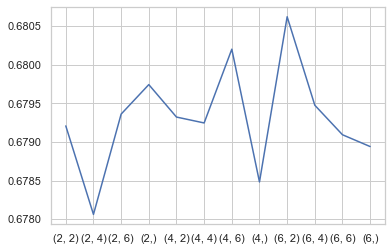

Best network structure: (6, 2) with accuracy: 0.6806202734703232


In [69]:
optimal_act = 'relu'
no_features = len(X_train_rf.columns)
alpha = 0.0001  # default

nodes_range = np.arange(2, no_features * 2 + 1, 2)
network_structures = []
accuracies = []

for layers in range(1,3):
    for first_nodes in nodes_range:    
        if layers == 1:
            network_structures.append((first_nodes,))
        elif layers == 2:
            for sec_nodes in nodes_range:
                network_structures.append((first_nodes, sec_nodes))
                
str_network_structures = []

for struct in network_structures:
    str_network_structures.append(str(struct))

best_acc = 0
best_struct = ()

for struct in network_structures:
    nn_model_cal = MLPClassifier(hidden_layer_sizes=struct, activation=optimal_act, alpha=alpha)
    nn_model_cal.fit(X_train_rf, y_train)
    predictions = nn_model_cal.predict(X_val_rf)
    acc = accuracy_score(y_val, predictions)
    
    if acc > best_acc:
        best_acc = acc
        best_struct = struct
    
    accuracies.append(acc)

plot_hyperparam(accuracies,str_network_structures)
print(f"Best network structure: {str(best_struct)} with accuracy: {best_acc}")

### Calibration of regularization parameter alpha

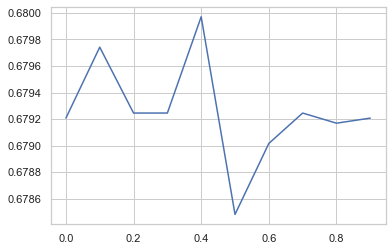

Best alpha: 0.4001 with accuracy: 0.6799709724238027


In [70]:
optimal_act = 'relu'
optimal_struct = (6, 2)
alphas = list(np.arange(0.0001, 1, 0.1))

accuracies = []
best_acc = 0
best_alpha = 0

for alpha in alphas:
    nn_model_cal = MLPClassifier(hidden_layer_sizes=optimal_struct, activation=optimal_act, alpha=alpha)
    nn_model_cal.fit(X_train_rf, y_train)
    predictions = nn_model_cal.predict(X_val_rf)
    acc = accuracy_score(y_val, predictions)
    
    if acc > best_acc:
        best_acc = acc
        best_alpha = alpha
    
    accuracies.append(acc)

plot_hyperparam(accuracies, alphas)

print(f"Best alpha: {best_alpha} with accuracy: {best_acc}")

### Cross validation score

In [71]:
optimal_act = 'relu'
optimal_struct = (6,2)
optimal_alpha = 0.4

nn_model_final = MLPClassifier(hidden_layer_sizes=optimal_struct, activation=optimal_act, alpha=optimal_alpha)
nn_scores = cross_val_score(nn_model_final, X_train_val_rf, y_train_val, cv=no_folds)
print("Neural Network accuracy: %0.3f (+/- %0.3f)" % (nn_scores.mean(), nn_scores.std() * 2))

Neural Network accuracy: 0.678 (+/- 0.011)


### Experiment: Running NN model on all features

Using default alpha and activation function given above and rule of thumb of 2 hidden layers just to see if we are missing out on any features.

In [73]:
no_nodes = int(round(len(X_train.columns)*2/3 + 1))
exp_act = 'relu'
exp_struct = (no_nodes, no_nodes)
exp_alpha = 0.0001

nn_model_exp = MLPClassifier(hidden_layer_sizes=exp_struct, activation=exp_act, alpha=exp_alpha)
nn_exp_scores = cross_val_score(nn_model_exp, X_train_val, y_train_val, cv=no_folds)
print("Neural Network (all features) accuracy: %0.3f (+/- %0.3f)" % (nn_exp_scores.mean(), nn_exp_scores.std() * 2))

Neural Network (all features) accuracy: 0.682 (+/- 0.007)


# 3. Testing

## Generalization error for a base model

Only looking at the ranking difference between the players

In [27]:
X_train_val_base = X_train_val.filter(['rank_diff'])
X_test_base = X_test.filter(['rank_diff'])

base_model = LogisticRegression(solver=lr_solver, C=1)
base_model.fit(X_train_val_base, X_test_base)
predictions = base_model.predict(X_test_base_full)
acc = accuracy_score(y_test, predictions)
print(f"Base model accuracy: {acc}")

Base model accuracy: 0.6482819971088625


## Generalization error for final model

An SVM model using auto scaling for gamma, and the rbf kernel was chosen as the final model due it superior performance. The three features that were finally used were rank_diff, points_grad_diff, rel_surface_wins.

In [88]:
X_test_rf = X_test.filter(rf_cols)

final_model = LogisticRegression(solver=lr_solver, C=1)
final_model.fit(X_train_val_rf, y_train_val)
predictions = final_model.predict(X_test_rf)
acc = accuracy_score(y_test, predictions)

print(f"Final model (LR) accuracy: {acc}")

Final model (LR) accuracy: 0.6774317373390997
